In [42]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm

# Load the FITS file
with fits.open("/Users/calvinsridhara/Documents/GitHub/M33_Analysis/Tables/m33_vels_stars_inc22B_donedupes.fits") as hdul:
    data = hdul[1].data
    df = pd.DataFrame(data.astype(data.dtype.newbyteorder('=')))

# Remove foreground stars
print(f"Total stars before Foreground removal: {len(df)}")
df = df[df['FG_SEL'] != 1].copy()
print(f"Total stars after Foreground removal: {len(df)}")

Total stars before Foreground removal: 5775
Total stars after Foreground removal: 5256


In [43]:
from collections import Counter

# Define the SEL flags to check
sel_flags = ['RGB_SEL', 'AGB_SEL', 'CBN_SEL', 'YMS_SEL', 'WCN_SEL', 'RHB_SEL', 'OHB_SEL' , 'FG_SEL']

def get_active_flags(row):
    return tuple(sorted([flag for flag in sel_flags if row[flag] == 1]))


df['sel_combo'] = df.apply(get_active_flags, axis=1)

# Count frequency of each unique flag combination
combo_counts = Counter(df['sel_combo'])

# Display results
print("Number of stars for each SEL flag combination:")
for combo, count in combo_counts.items():
    label = ', '.join(combo) if combo else 'None'
    print(f"{label}: {count}")

Number of stars for each SEL flag combination:
RGB_SEL: 2361
AGB_SEL: 642
OHB_SEL: 475
RHB_SEL: 636
YMS_SEL: 308
OHB_SEL, WCN_SEL: 44
AGB_SEL, CBN_SEL: 144
RHB_SEL, WCN_SEL: 475
CBN_SEL, RHB_SEL: 10
RGB_SEL, WCN_SEL: 57
AGB_SEL, WCN_SEL: 58
CBN_SEL, RGB_SEL: 21
WCN_SEL, YMS_SEL: 4
None: 20
WCN_SEL: 1


In [44]:

df['age_group'] = 'unclassified'


df.loc[df['WCN_SEL'] == 1, 'age_group'] = 'young'
df.loc[df['CBN_SEL'] == 1, 'age_group'] = 'int'


df.loc[
    (df['age_group'] == 'unclassified') & (df['RGB_SEL'] == 1),
    'age_group'
] = 'old'


df.loc[
    (df['age_group'] == 'unclassified') & (df['AGB_SEL'] == 1),
    'age_group'
] = 'int'

df.loc[
    (df['age_group'] == 'unclassified') & 
    ((df['YMS_SEL'] == 1) | (df['OHB_SEL'] == 1) | (df['RHB_SEL'] == 1)),
    'age_group'
] = 'young'


print(df['age_group'].value_counts())

age_group
old             2361
young           2058
int              817
unclassified      20
Name: count, dtype: int64


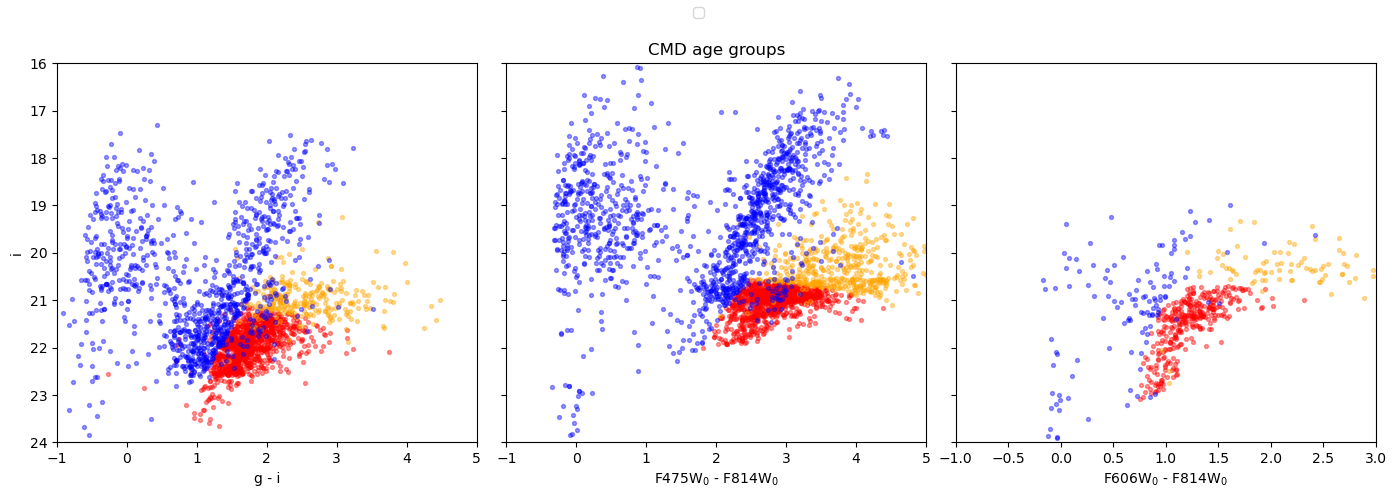

In [45]:
# Filter data by availability of magnitudes
df1 = df[(df['g'].notnull()) & (df['i'].notnull())]
df2 = df[(df['F475W0_ACS'].notnull()) & (df['F814W0_ACS'].notnull())]
df3 = df[(df['F606W0_ACS'].notnull()) & (df['F814W0_ACS'].notnull())]

# Set color and label mappings
colors = {'young': 'blue', 'int': 'orange', 'old': 'red'}
labels = {'young': 'young', 'int': 'intermediate', 'old': 'old'}

# Plot CMDs
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

# Panel 1: g - i vs i
for group in ['old', 'int', 'young']:
    subset = df1[df1['age_group'] == group]
    axes[0].scatter(subset['g'] - subset['i'], subset['i'], color=colors[group], s=8, alpha=0.4)
axes[0].invert_yaxis()
axes[0].set_xlim(-1, 5)
axes[0].set_ylim(24, 16)
axes[0].set_xlabel('g - i')
axes[0].set_ylabel('i')

# Panel 2: F475W0 - F814W0
for group in ['old', 'int', 'young']:
    subset = df2[df2['age_group'] == group]
    axes[1].scatter(subset['F475W0_ACS'] - subset['F814W0_ACS'], subset['F814W0_ACS'], color=colors[group], s=8, alpha=0.4)
axes[1].invert_yaxis()
axes[1].set_xlim(-1, 5)
axes[1].set_ylim(24, 16)
axes[1].set_xlabel('F475W$_0$ - F814W$_0$')
axes[1].set_title('CMD age groups')

# Panel 3: F606W0 - F814W0
for group in ['old', 'int', 'young']:
    subset = df3[df3['age_group'] == group]
    axes[2].scatter(subset['F606W0_ACS'] - subset['F814W0_ACS'], subset['F814W0_ACS'], color=colors[group], s=8, alpha=0.4)
axes[2].invert_yaxis()
axes[2].set_xlim(-1, 3)
axes[2].set_ylim(24, 16)
axes[2].set_xlabel('F606W$_0$ - F814W$_0$')

# Add unified legend
fig.legend(*axes[0].get_legend_handles_labels(), loc='upper center', ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

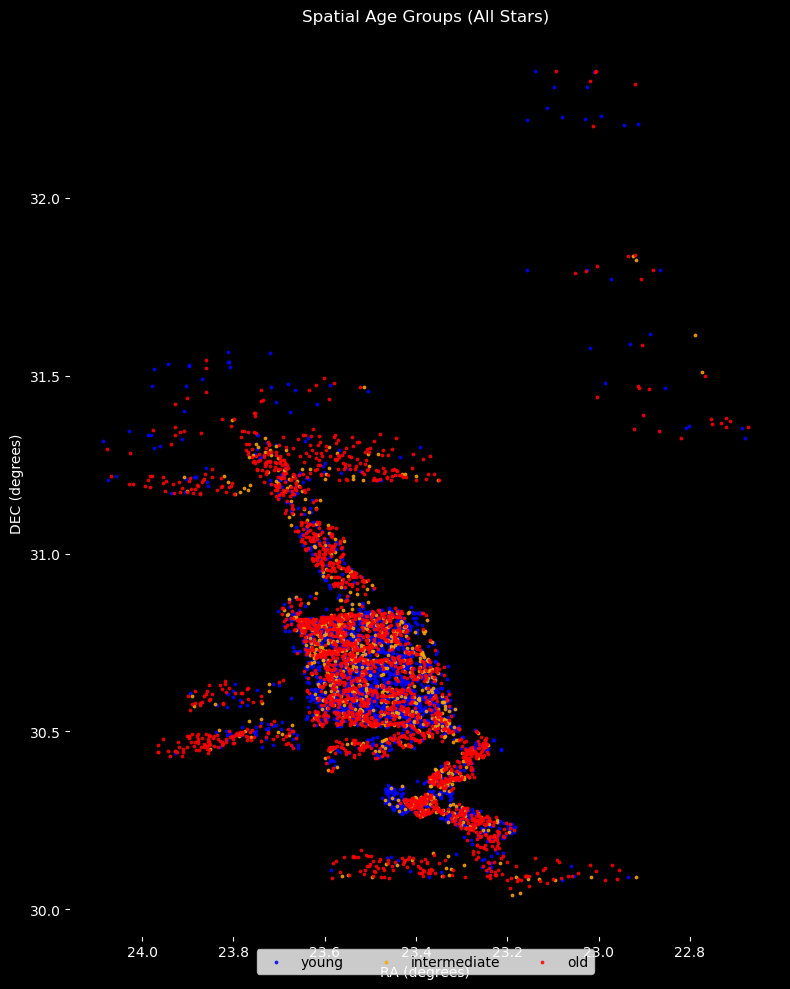

In [46]:
plt.figure(figsize=(8, 10), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

for group in ['young', 'int', 'old']:
    subset = df[df['age_group'] == group]
    plt.scatter(subset['RA_DEG'], subset['DEC_DEG'], color=colors[group], s=3, label=labels[group], alpha=0.8)

plt.xlabel("RA (degrees)", color='white')
plt.ylabel("DEC (degrees)", color='white')
plt.tick_params(colors='white')
plt.gca().invert_xaxis()
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.title("Spatial Age Groups (All Stars)", color='white')
plt.tight_layout()
plt.show()

In [58]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

# 1. Filter out any null positions
df = df[df['RA_DEG'].notnull() & df['DEC_DEG'].notnull()].copy()

# 2. Build SkyCoord objects
center = SkyCoord(ra=23.4621*u.deg, dec=30.6602*u.deg)  # M33 center
stars  = SkyCoord(ra=df['RA_DEG'].values*u.deg,
                  dec=df['DEC_DEG'].values*u.deg)

# 3. Compute sky-plane offsets in arcmin
offs = stars.transform_to(center.skyoffset_frame())
xi_arcmin  = offs.lon.degree * 60.0   
eta_arcmin = offs.lat.degree * 60.0   

# 4. Galaxy geometry (you can adjust these to your preferred values)
PA_deg  = 22    # position angle of M33’s major axis (deg east of north)
inc_deg = 52    # inclination of M33’s disk (deg)
PA  = np.deg2rad(PA_deg)
inc = np.deg2rad(inc_deg)

alpha = eta_arcmin * np.cos(PA) + xi_arcmin * np.sin(PA)   
beta  = -eta_arcmin * np.sin(PA) + xi_arcmin * np.cos(PA)  

# 6. “Un-tilt” the minor-axis coordinate
beta_prime = beta / np.cos(inc)

r_deproj_arcmin = np.sqrt(alpha**2 + beta_prime**2)

scale = (np.pi/180/60) * 794
df['r_deproj_arcmin'] = r_deproj_arcmin
df['r_deproj_kpc']    = r_deproj_arcmin * scale



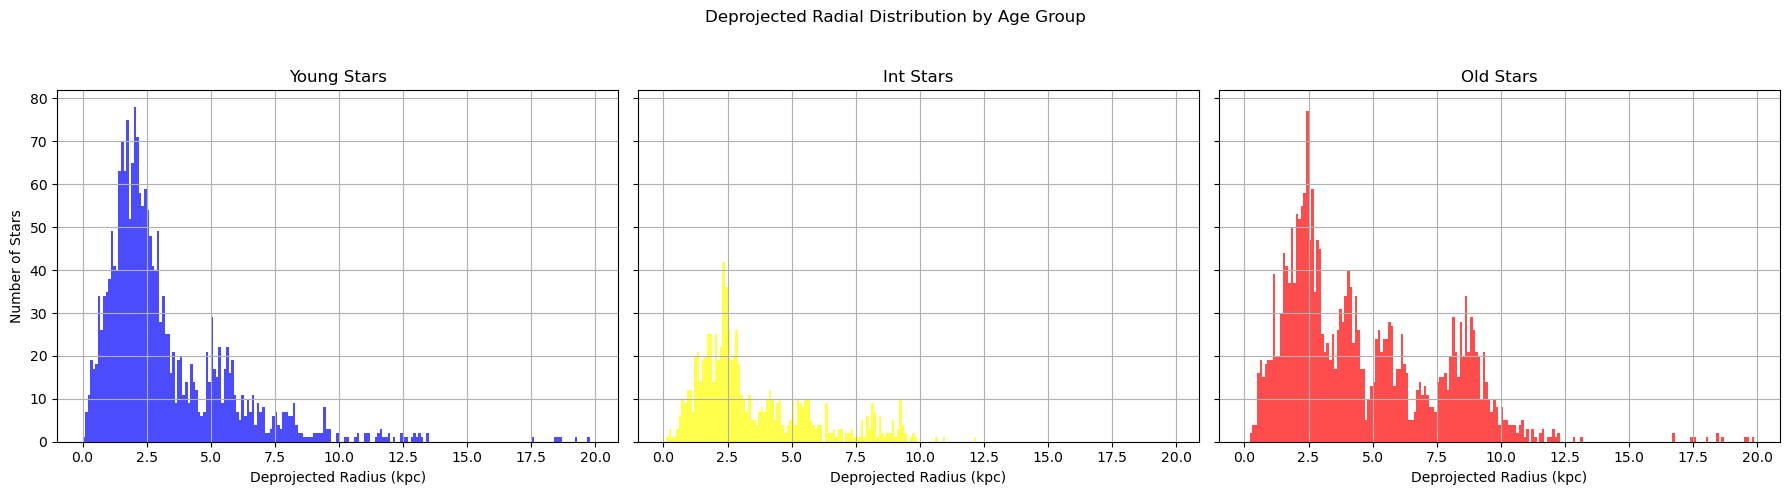

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# === Deprojected radial histogram by age ===
bins = np.arange(0, 20, 0.1)
age_groups = ['young', 'int', 'old']
colors = {'young': 'blue', 'int': 'yellow', 'old': 'red'}

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, group in zip(axes, age_groups):
    subset = df[df['age_group'] == group]
    ax.hist(
        subset['r_deproj_kpc'],
        bins=bins,
        histtype='stepfilled',
        color=colors[group],
        alpha=0.7
    )
    ax.set_title(f'{group.capitalize()} Stars')
    ax.set_xlabel('Deprojected Radius (kpc)')
    if ax is axes[0]:
        ax.set_ylabel('Number of Stars')
    ax.grid(True)

plt.suptitle('Deprojected Radial Distribution by Age Group')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [54]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
from tqdm import tqdm

# === Split by age group ===
young_df = df[df['age_group'] == 'young'].copy()
int_df   = df[df['age_group'] == 'int'].copy()
old_df   = df[df['age_group'] == 'old'].copy()

# === Create SkyCoord objects ===
young_coords = SkyCoord(ra=young_df['RA_DEG'].values * u.deg, dec=young_df['DEC_DEG'].values * u.deg)
int_coords   = SkyCoord(ra=int_df['RA_DEG'].values * u.deg, dec=int_df['DEC_DEG'].values * u.deg)
old_coords   = SkyCoord(ra=old_df['RA_DEG'].values * u.deg, dec=old_df['DEC_DEG'].values * u.deg)

# === Matching ===
matched_triplets = []
match_radius = 1.0 * u.arcminute

used_int = set()
used_old = set()

for i in tqdm(range(len(young_df)), desc="Matching triplets from young base"):
    young_star = young_coords[i]

    # Match to int stars
    idx_int, sep2d_int, _ = young_star.match_to_catalog_sky(int_coords)
    idx_int = int(idx_int)  # extract integer
    if sep2d_int > match_radius or idx_int in used_int:
        continue

    # Match to old stars
    idx_old, sep2d_old, _ = young_star.match_to_catalog_sky(old_coords)
    idx_old = int(idx_old)  # extract integer
    if sep2d_old > match_radius or idx_old in used_old:
        continue

    used_int.add(idx_int)
    used_old.add(idx_old)

    matched_triplets.append({
        'young_idx': young_df.index[i],
        'int_idx': int_df.iloc[idx_int].name,
        'old_idx': old_df.iloc[idx_old].name
    })

# === Output ===
triplets_df = pd.DataFrame(matched_triplets)
print(f"Matched triplets found: {len(triplets_df)}")

Matching triplets from young base: 100%|██| 2058/2058 [00:01<00:00, 1593.93it/s]

Matched triplets found: 548


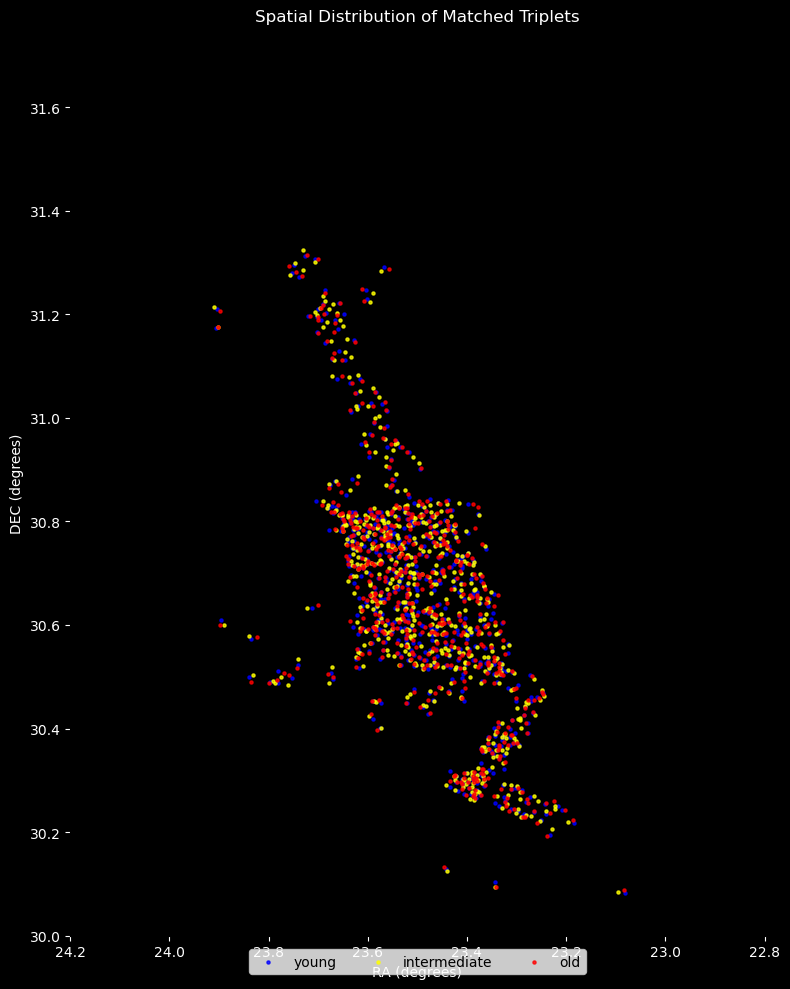

In [55]:
triplet_full_data = pd.concat([
    df.loc[triplets_df['old_idx']].assign(group='old'),
    df.loc[triplets_df['int_idx']].assign(group='int'),
    df.loc[triplets_df['young_idx']].assign(group='young')
]).reset_index(drop=True)


triplet_full_data = triplet_full_data[triplet_full_data['RA_DEG'].notnull() & triplet_full_data['DEC_DEG'].notnull()]

plt.figure(figsize=(8, 10), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

for group in ['young', 'int', 'old']:
    subset = triplet_full_data[triplet_full_data['group'] == group]
    plt.scatter(subset['RA_DEG'], subset['DEC_DEG'], color=colors[group], s=5, label=labels[group], alpha=0.8)

plt.xlabel("RA (degrees)", color='white')
plt.ylabel("DEC (degrees)", color='white')
plt.xlim(22.8, 24.2)
plt.ylim(30, 31.75)
plt.tick_params(colors='white')
plt.gca().invert_xaxis()
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.title("Spatial Distribution of Matched Triplets", color='white')
plt.tight_layout()
plt.show()

In [32]:
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.interpolate import interp1d

# === Load disk model ===
diskmodel = Table.read('./Codes/Kam2017_table4.dat', format='ascii',
                       names=['Radius_arcmin', 'Radius_kpc', 'Vrot_kms', 'Delta_Vrot', 'i_deg', 'PA_deg'])


m33coord = SkyCoord(ra='01h33m50.9s', dec='+30d39m36s', unit=(u.hourangle, u.deg))
v_sys = -180.0  # systemic velocity of M33


def major_minor_transform(coords, pa, centercoords=m33coord):
    c_offset = coords.transform_to(centercoords.skyoffset_frame())
    xi, eta = c_offset.lon.degree, c_offset.lat.degree
    alpha = eta * np.cos(pa) + xi * np.sin(pa)
    beta =  - eta * np.sin(pa) + xi * np.cos(pa)
    return alpha, beta

def compute_model_los_velocity(coords):
    Rinit = np.sqrt((coords.ra.degree - m33coord.ra.degree)**2 +
                    (coords.dec.degree - m33coord.dec.degree)**2)
    R_arcmin = Rinit * 60.0

    f_pa = interp1d(diskmodel['Radius_arcmin'], diskmodel['PA_deg'], fill_value="extrapolate")
    f_incl = interp1d(diskmodel['Radius_arcmin'], diskmodel['i_deg'], fill_value="extrapolate")
    f_vrot = interp1d(diskmodel['Radius_arcmin'], diskmodel['Vrot_kms'], fill_value="extrapolate")

    pa = f_pa(R_arcmin) * u.deg
    incl = f_incl(R_arcmin) * u.deg
    vrot = f_vrot(R_arcmin)

    alpha, beta = major_minor_transform(coords, pa)
    phi = np.arctan2(beta / np.cos(incl), alpha)

    vlos = v_sys + vrot * np.sin(incl) * np.cos(phi)
    return vlos

# === Apply model to triplet data ===
triplet_coords = SkyCoord(ra=triplet_full_data['RA_DEG'].values * u.deg,
                          dec=triplet_full_data['DEC_DEG'].values * u.deg)
triplet_full_data['model_vlos'] = compute_model_los_velocity(triplet_coords)

# === Group stars by age ===
youngs = triplet_full_data[triplet_full_data['group'] == 'young'].reset_index(drop=True)
ints   = triplet_full_data[triplet_full_data['group'] == 'int'].reset_index(drop=True)
olds   = triplet_full_data[triplet_full_data['group'] == 'old'].reset_index(drop=True)

# === Create summary DataFrame ===
triplet_grouped = pd.DataFrame({
    'young_RA': youngs['RA_DEG'],
    'young_DEC': youngs['DEC_DEG'],
    'young_vlos': youngs['model_vlos'],
    'young_vcorr_stat': youngs['VCORR_STAT'],

    'int_RA': ints['RA_DEG'],
    'int_DEC': ints['DEC_DEG'],
    'int_vlos': ints['model_vlos'],
    'int_vcorr_stat': ints['VCORR_STAT'],

    'old_RA': olds['RA_DEG'],
    'old_DEC': olds['DEC_DEG'],
    'old_vlos': olds['model_vlos'],
    'old_vcorr_stat': olds['VCORR_STAT']
})

print(triplet_grouped)

      young_RA  young_DEC  young_vlos  young_vcorr_stat     int_RA    int_DEC  \
0    23.589292  30.419000 -139.987354       -118.784611  23.584625  30.420806   
1    23.484625  30.428111 -120.501864       -123.413760  23.478125  30.428500   
2    23.489125  30.441944 -122.569522       -115.278228  23.489375  30.445639   
3    23.456917  30.461250 -116.380088        -88.192689  23.455833  30.452000   
4    23.495708  30.463667 -126.017379        -95.833470  23.495750  30.479611   
..         ...        ...         ...               ...        ...        ...   
569  23.366667  30.537056 -115.477331       -104.062771  23.365833  30.538333   
570  23.489542  30.781333 -237.908541       -238.464863  23.490375  30.773917   
571  23.425167  30.778417 -217.725815       -209.133341  23.419417  30.777639   
572  23.537958  30.755667 -235.925362       -232.746240  23.535458  30.749972   
573  23.509917  30.526917 -139.966077       -134.533084  23.504083  30.525778   

       int_vlos  int_vcorr_